In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn,fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import faster_rcnn
# from torchvision.models.detection import BackboneWithFPN
import numpy as np
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
from torchvision import models, datasets, tv_tensors
from helpers import plot
from torchvision.transforms import v2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from torch.utils.data import ConcatDataset, DataLoader

# Ensure you have the correct COCO dataset, or use a different dataset
# This example assumes you're using COCO format dataset, but similar for VOC
coco_gt = COCO(r"C:\Users\wajah\Downloads\ALL\H_100X_C2\json_labels\test.json")

# Data Transformations
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomApply(transforms=[v2.RandomIoUCrop()],p=0.5),
        v2.RandomPerspective(distortion_scale=0.3,fill={tv_tensors.Image: (123, 117, 104), "others": 0}, p=0.5),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0},side_range=(1.0, 2.0),p=0.5),
        v2.RandomApply(transforms=[v2.ColorJitter(brightness=0.5,contrast=0.3,saturation=0.3)],p=0.5),
        v2.RandomHorizontalFlip(p=1),
        v2.Resize((640,640),antialias=True),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
        # v2.RandomApply(transforms=[v2.GaussianNoise(sigma=0.05)],p=0.5),
    ]
)

test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)


# Load COCO Dataset (you can change it for VOC dataset)
train_dataset = CocoDetection(
    root=r"C:\Users\wajah\Downloads\ALL\H_100X_C2\images\train",
    annFile=r"C:\Users\wajah\Downloads\ALL\H_100X_C2\json_labels\train.json",
    transforms=transforms
)

dataset_0 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset = CocoDetection(
    root=r"C:\Users\wajah\Downloads\ALL\H_100X_C2\images\test",
    annFile=r"C:\Users\wajah\Downloads\ALL\H_100X_C2\json_labels\test.json",
    transforms=test_transforms
)

test_dataset = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels","image_id"))



train_loader = torch.utils.data.DataLoader(
    dataset_0,
    batch_size=4,
    shuffle=True,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['image_id', 'boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>
692


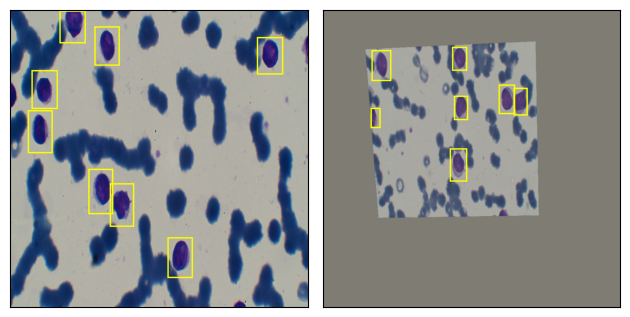

In [2]:
sample = test_dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")
plot([dataset_0[5], dataset_0[1]])
print(len(test_loader))

In [3]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    # model= torchvision.models.detection.retinanet_resnet50_fpn_v2(weights='COCO_V1')
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    return model

num_classes = 15
model = create_model(num_classes)

# model.load_state_dict(torch.load(r"C:\Users\wajah\Downloads\ALL\best_model(FasterRCNN)_adamw_640_50.pth"))
# from torchvision.models import resnet50, ResNet50_Weights

# model= torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=None,num_classes=15, weights_backbone = ResNet50_Weights.IMAGENET1K_V2)

In [4]:
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# from torchvision.models import resnet50, ResNet50_Weights

# # Setup
# backbone = resnet_fpn_backbone(backbone_name='resnet50', weights="IMAGENET1K_V1")
# model = FasterRCNN(backbone=backbone, num_classes=15,min_size=640,max_size=640)


# import torchvision
# from torchvision.models.detection import RetinaNet
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
# from torchvision.models import resnet50, ResNet50_Weights

# # Load a pretrained ResNet101 backbone with FPN
# backbone = resnet_fpn_backbone(
#     backbone_name='resnet50',
#     weights=ResNet50_Weights.IMAGENET1K_V1,
#     # trainable_layers=3  # Optional: freeze earlier layers
# )

# # Create the RetinaNet model
# model = RetinaNet(backbone=backbone, num_classes=15,min_size=640,max_size=640)
# print(model)

In [5]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

from tqdm import tqdm

def train_one_epoch(model, train_loader, optimizer, scaler, accumulation_steps, device):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", unit="batch")

    optimizer.zero_grad()

    for i, (images, targets) in progress_bar:
        images = [img.to(device) for img in images]
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Normalize loss for accumulation
        loss = losses / accumulation_steps
        loss.backward()

        # Only update weights every `accumulation_steps` iterations
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

        train_loss += losses.item()  # Add actual (un-normalized) loss
        progress_bar.set_postfix(loss=losses.item())

    avg_train_loss = train_loss / len(train_loader)
    return avg_train_loss


from pycocotools.cocoeval import COCOeval
import numpy as np

def validate(model, val_loader, device, coco_gt):
    model.eval()  # Use eval mode for evaluation
    predictions = []
    image_ids = []
    annotation_id = 0  # Unique ID across all predictions

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id']
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    width = x_max - x_min
                    height = y_max - y_min

                    predictions.append({
                        'image_id': image_id,
                        'category_id': int(label),
                        'bbox': [x_min, y_min, width, height],
                        'score': float(score)
                    })

    # Evaluate with COCO API
    coco_dt = coco_gt.loadRes(predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    mAP_50_95 = coco_eval.stats[0]  # mAP@[0.50:0.95]
    mAP_50 = coco_eval.stats[1]     # mAP@0.50

    return mAP_50, mAP_50_95

def train_and_evaluate(model, train_loader, val_loader, optimizer, scaler, accumulation_steps,
                       lr_scheduler, num_epochs, device, coco_gt, model_save_path='best_model.pth'):
    best_map = 0.0
    epochs_no_improve = 0
    patience = 50  # Early stopping patience
    # avg_train_loss=0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        avg_train_loss = train_one_epoch(model, train_loader, optimizer, scaler, accumulation_steps, device)

        # Validation - returns mAP@50 and mAP@[.50:.95]
        mAP_50, mAP_50_95 = validate(model, val_loader, device, coco_gt)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - "
              f"mAP@50: {mAP_50:.4f} - mAP@[.50:.95]: {mAP_50_95:.4f}")

        # Save the model if mAP@[.50:.95] improved
        if mAP_50 > best_map:
            print("Validation mAP improved, saving the model...")
            best_map = mAP_50
            torch.save(model.state_dict(), model_save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epochs_no_improve} epochs without improvement.")
            break

        # Update learning rate scheduler
        lr_scheduler.step()

    print("Training complete!")




In [6]:
import matplotlib.pyplot as plt
import numpy as np

def find_lr(model, train_loader, optimizer, device, init_value=1e-7, final_value=10., beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = float('inf')
    batch_num = 0
    losses = []
    log_lrs = []

    model.train()

    for batch_num, (images, targets) in enumerate(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**(batch_num + 1))

        log_lrs.append(np.log10(lr))
        losses.append(smoothed_loss)

        loss.backward()
        optimizer.step()

        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        if smoothed_loss < best_loss or batch_num == 0:
            best_loss = smoothed_loss

    return log_lrs, losses


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Mixed precision scaler
scaler = GradScaler()

# Gradient accumulation setup
accumulation_steps = 4
num_epochs = 100
# Define the save path for the best model
model_save_path = 'Faster_v2_model_adamw_640_50.pth'

# log_lrs, losses= find_lr(model, train_loader, optimizer, device, init_value=1e-5, final_value=10.0, beta=0.98)

# # # log_lrs, losses = find_lr(model, train_loader, optimizer, device)
# # # 
# plt.plot(log_lrs, losses)
# plt.xlabel("Log10 Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Finder")
# plt.grid(True)
# plt.show()

# Train and evaluate
train_and_evaluate(model, train_loader, test_loader, optimizer, scaler, accumulation_steps, lr_scheduler, num_epochs, device,coco_gt, model_save_path)


C:\Users\wajah\AppData\Local\Temp\ipykernel_14492\2145411511.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/100


Training:   0%|          | 0/420 [00:05<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:

train_and_evaluate(model, train_loader, test_loader, optimizer, scaler, accumulation_steps, lr_scheduler, num_epochs, device,coco_gt, model_save_path)

In [ ]:
torch.save(model.state_dict(), "final_model.pth")

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2 as T
from torchvision import datasets
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import torchvision

# ----------------------------
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Define test transforms
test_transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    # T.Resize((512, 512)),
    # T.ToTensor()
])

# ----------------------------
# Load COCO annotation and dataset
coco = COCO(r"C:\Users\wajah\Downloads\ALL\H_40X_C2\json_labels\test.json")

test_dataset = CocoDetection(
    root=r'C:\Users\wajah\Downloads\ALL\H_40X_C2\images\test',
    annFile=r"C:\Users\wajah\Downloads\ALL\H_40X_C2\json_labels\test.json",
    transforms=test_transforms
)

# Optional: wrap dataset for TorchVision v2
dataset = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels", "image_id"))

# ----------------------------
# Load Faster R-CNN model
model =torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=15)  # <-- change num_classes based on your dataset

# fasterrcnn_resnet50_fpn
# model.load_state_dict(torch.load("final_model.pth", map_location=device))
model.load_state_dict(torch.load(r"C:\Users\wajah\Downloads\ALL\Faster_v2_model_adamw_640_50.pth", map_location=device))
# Define the save path for the best model
# model_save_path = 'best_model_adamw_640_50.pth'

model.to(device)
model.eval()

# ----------------------------
# Run inference and build predictions in COCO format
predictions = []

for idx in range(len(dataset)):
    image, target = dataset[idx]

    image = image.to(device)
    image_id = target["image_id"].item() if isinstance(target["image_id"], torch.Tensor) else target["image_id"]

    with torch.no_grad():
        outputs = model([image])

    output = outputs[0]

    for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
        x1, y1, x2, y2 = box.tolist()
        width = x2 - x1
        height = y2 - y1
        coco_box = [x1, y1, width, height]

        predictions.append({
            "image_id": image_id,
            "category_id": int(label.item()),
            "bbox": coco_box,
            "score": float(score.item())
        })

# ----------------------------
# Load predictions into COCOeval
coco_dt = coco.loadRes(predictions)
coco_eval = COCOeval(coco, coco_dt, iouType='bbox')

# Evaluate and summarize
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
